In [1]:
import os
import shutil

main_directory = "/Users/rich/Desktop/AI-music/Datasets/"

#move files from subfolders to main folder
for folder_name in os.listdir(main_directory):
    folder_path = os.path.join(main_directory, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name) 
            if file_name != ".DS_Store":
                destination_path = os.path.join(main_directory, file_name)
                shutil.move(file_path, destination_path)
#del subfolders
for folder_name in os.listdir(main_directory):
    folder_path = os.path.join(main_directory, folder_name)
    if os.path.isdir(folder_path):
        shutil.rmtree(folder_path)
#rename files
count = 1
for file_name in os.listdir(main_directory):
    file_path = os.path.join(main_directory, file_name)
    if os.path.isfile(file_path):
        new_file_name = str(count) + os.path.splitext(file_name)[1]
        new_file_path = os.path.join(main_directory, new_file_name)
        os.rename(file_path, new_file_path)
        count += 1

#rename files
count = 1
for file_name in os.listdir(main_directory):
    file_path = os.path.join(main_directory, file_name)
    if os.path.isfile(file_path):
        new_file_name = str(count) + os.path.splitext(file_name)[1]
        new_file_path = os.path.join(main_directory, new_file_name)
        os.rename(file_path, new_file_path)
        count += 1

In [2]:
import pretty_midi
import numpy as np
import glob


midi_file_paths = glob.glob('/Users/rich/Desktop/AI-music/Datasets/*.mid')

all_notes = []
all_velocities = []

#midi file processing 
#有些midi文件有问题，所以用try except
for file_path in midi_file_paths:
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)
        notes = []
        velocities = []

        for instrument in midi_data.instruments:
            for note in instrument.notes:
                notes.append(note.pitch)
                velocities.append(note.velocity)

        all_notes.extend(notes)
        all_velocities.extend(velocities)
    except:
        pass

notes_array = np.array(all_notes)
velocities_array = np.array(all_velocities)



/Users/Rich/Library/Python/3.9/lib/python/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [4]:
#normalize
notes_normalized = notes_array.reshape(-1, 1) / float(notes_array.max())
velocities_normalized = velocities_array.reshape(-1, 1) / float(velocities_array.max())

# combine notes and velocities
combined_data = np.concatenate((notes_normalized, velocities_normalized), axis=1)


In [5]:
sequence_length = 100
inputs = []
targets = []

for i in range(len(combined_data) - sequence_length):
    inputs.append(combined_data[i:i+sequence_length])
    targets.append(combined_data[i+sequence_length])

inputs = np.array(inputs)
targets = np.array(targets)

In [6]:
#split data
split_index = int(0.8 * len(inputs)) 

train_inputs = inputs[:split_index]
train_targets = targets[:split_index]

test_inputs = inputs[split_index:]
test_targets = targets[split_index:]

In [8]:
#build model
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, input_shape=(sequence_length, combined_data.shape[1])),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(combined_data.shape[1], activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(train_inputs, train_targets, epochs=25, batch_size=64)
model.save('/Users/rich/Desktop/AI-music/Models/model02')

Epoch 1/30


2023-06-06 00:11:32.242992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-06 00:11:32.464090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-06 00:11:32.792542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19356/19356 [==============================] - 713s 37ms/step - loss: 0.0078
Epoch 2/30
19356/19356 [==============================] - 711s 37ms/step - loss: 0.0063
Epoch 3/30
19356/19356 [==============================] - 715s 37ms/step - loss: 0.0053
Epoch 4/30
19356/19356 [==============================] - 718s 37ms/step - loss: 0.0048
Epoch 5/30
19356/19356 [==============================] - 719s 37ms/step - loss: 0.0044
Epoch 6/30
19356/19356 [==============================] - 721s 37ms/step - loss: 0.0041
Epoch 7/30
19356/19356 [==============================] - 719s 37ms/step - loss: 0.0039
Epoch 8/30
19356/19356 [==============================] - 721s 37ms/step - loss: 0.0037
Epoch 9/30
19356/19356 [==============================] - 720s 37ms/step - loss: 0.0036
Epoch 10/30
19356/19356 [==============================] - 723s 37ms/step - loss: 0.0034
Epoch 11/30
19356/19356 [==============================] - 756s 39ms/step - loss: 0.0033
Epoch 12/30
19356/19356 [================

INFO:tensorflow:Assets written to: /Users/rich/Desktop/AI-music/Models/model01/assets


INFO:tensorflow:Assets written to: /Users/rich/Desktop/AI-music/Models/model01/assets


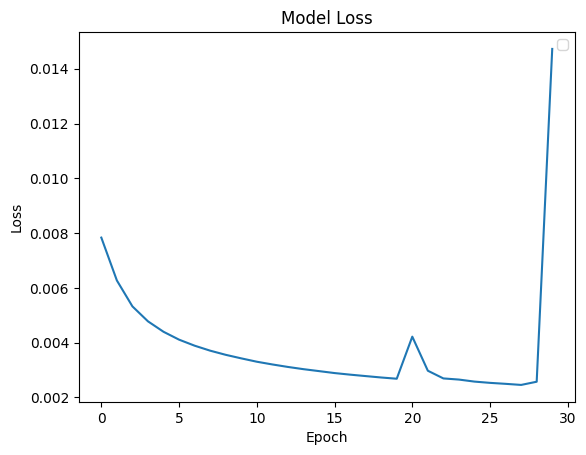

In [9]:
#plot loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [10]:
#generate music
generated_sequence = []


start_index = np.random.randint(0, len(test_inputs)-1)
input_sequence = test_inputs[start_index]
sequence_length = 30

for _ in range(sequence_length):
    predicted = model.predict(np.expand_dims(input_sequence, axis=0))
    generated_sequence.append(predicted[0])
    input_sequence = np.concatenate((input_sequence[1:], np.expand_dims(predicted[0], axis=0)))

generated_sequence = notes_array.max() * generated_sequence


2023-06-06 06:27:21.735023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-06 06:27:21.830834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 25ms/step


In [11]:
#convert to midi
from music21 import stream, note, tempo

music_stream = stream.Stream()
default_tempo = tempo.MetronomeMark(number=120)

for sequence in generated_sequence:
    pitch = int(sequence[0])  
    duration = float(sequence[1])  

    n = note.Note()
    n.pitch.midi = pitch
    n.duration.quarterLength = duration

    music_stream.append(n)

music_stream.insert(0, default_tempo)

midi_filename = "generated_music.mid"
music_stream.write("midi", fp=midi_filename)


'generated_music.mid'